# Track Linearization: Advanced Features Tutorial

This tutorial covers advanced features of the `track_linearization` package introduced in v2.4+.

**What you'll learn:**
1. Using pre-built track geometries with track builders
2. Validating track structures and assessing linearization quality
3. Building custom tracks interactively from images
4. Detecting outliers and calculating confidence scores
5. Best practices for real-world analysis workflows

**Prerequisites:** Complete the basic tutorial ([track_linearization_tutorial.ipynb](track_linearization_tutorial.ipynb)) first. Basic knowledge of spatial tracking experiments is helpful.

## Setup

Import the necessary libraries and configure plotting.

In [1]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Track linearization - core functions
from track_linearization import (
    get_linearized_position,
    project_1d_to_2d,
)

# Track builders
from track_linearization import (
    make_linear_track,
    make_circular_track,
    make_tmaze_track,
    make_plus_maze_track,
    make_figure8_track,
    make_wtrack,
    make_rectangular_track,
    make_ymaze_track,
    make_track_from_points,
)

# Validation & QC
from track_linearization import (
    check_track_graph_validity,
    get_projection_confidence,
    detect_linearization_outliers,
    validate_linearization,
)

# Utilities
from track_linearization import (
    make_track_graph,
    plot_track_graph,
    plot_graph_as_1D,
    infer_edge_layout,
)

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ All imports successful!")

✓ All imports successful!


---
## Part 1: Track Builders

Track builders provide quick ways to create common experimental geometries without manually specifying coordinates.

### Concept
Instead of defining node positions and edges by hand, you can use builder functions that generate complete track structures with a single function call. This is faster, less error-prone, and makes your code more readable.

### Example 1: Linear Track

In [2]:
# Create a 100 cm linear track with one function call
linear_track = make_linear_track(length=100, start_pos=(0, 0))

print(f"Created track with {linear_track.number_of_nodes()} nodes and {linear_track.number_of_edges()} edge")
print(f"Track length: {linear_track.edges[0, 1]['distance']:.1f} cm")

Created track with 2 nodes and 1 edge
Track length: 100.0 cm


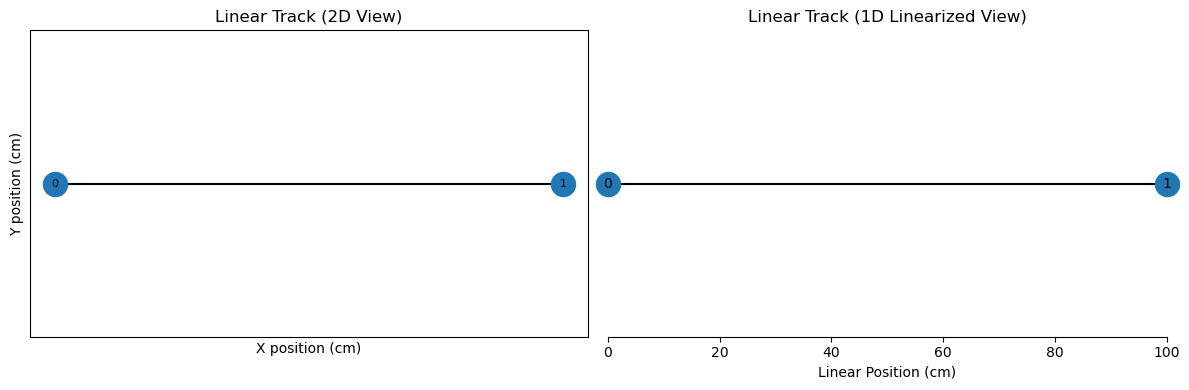

In [3]:
# Visualize in 2D and 1D
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 2D view
plot_track_graph(linear_track, ax=ax1)
ax1.set_title('Linear Track (2D View)')
ax1.set_xlabel('X position (cm)')
ax1.set_ylabel('Y position (cm)')

# 1D linearized view
plot_graph_as_1D(linear_track, ax=ax2)
ax2.set_title('Linear Track (1D Linearized View)')
ax2.set_xlabel('Linear Position (cm)')

plt.tight_layout()
plt.show()

### Example 2: Circular Track

Circular tracks are approximated using multiple connected line segments. More segments = smoother circle.

In [4]:
# Create a circular track with 50 cm radius
circular_track = make_circular_track(radius=50, center=(0, 0), n_segments=24)

# Calculate actual vs theoretical circumference
total_distance = sum(edge_data['distance'] for _, _, edge_data in circular_track.edges(data=True))
expected_circumference = 2 * np.pi * 50

print(f"Track circumference: {total_distance:.2f} cm")
print(f"Expected (2πr): {expected_circumference:.2f} cm")
print(f"Approximation error: {abs(total_distance - expected_circumference):.2f} cm")

Track circumference: 313.26 cm
Expected (2πr): 314.16 cm
Approximation error: 0.90 cm


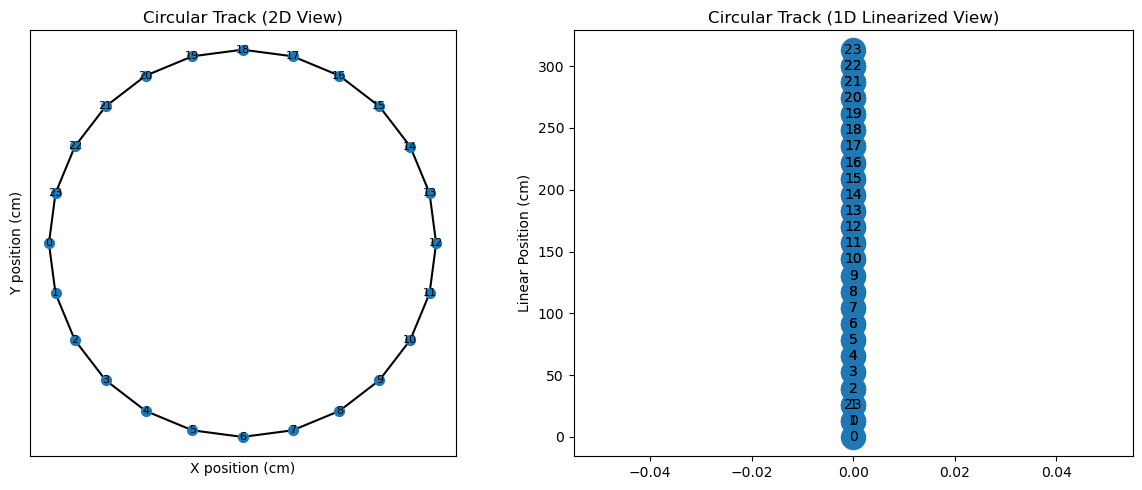

In [5]:
# Visualize circular track
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_track_graph(circular_track, ax=ax1, node_size=50)
ax1.set_title('Circular Track (2D View)')
ax1.set_aspect('equal')
ax1.set_xlabel('X position (cm)')
ax1.set_ylabel('Y position (cm)')

# Show as 1D - use axis='y' for vertical orientation
plot_graph_as_1D(circular_track, ax=ax2, axis='y')
ax2.set_title('Circular Track (1D Linearized View)')
ax2.set_ylabel('Linear Position (cm)')

plt.tight_layout()
plt.show()

💡 **Note:** The `axis='y'` parameter displays the linearized track vertically instead of horizontally.

### Example 3: T-Maze

T-mazes are common for spatial alternation tasks. The builder creates the stem and two arms automatically.

In [6]:
# Create T-maze: 60 cm stem, 40 cm arms, 20 cm spacing between arms
tmaze = make_tmaze_track(stem_length=60, arm_length=40, arm_spacing=20)

print(f"T-maze created with {tmaze.number_of_nodes()} nodes and {tmaze.number_of_edges()} edges")

# Check the edge structure
edge_order, _ = infer_edge_layout(tmaze)
print(f"Inferred edge order: {edge_order}")

T-maze created with 4 nodes and 3 edges
Inferred edge order: [(0, 1), (1, 2), (1, 3)]


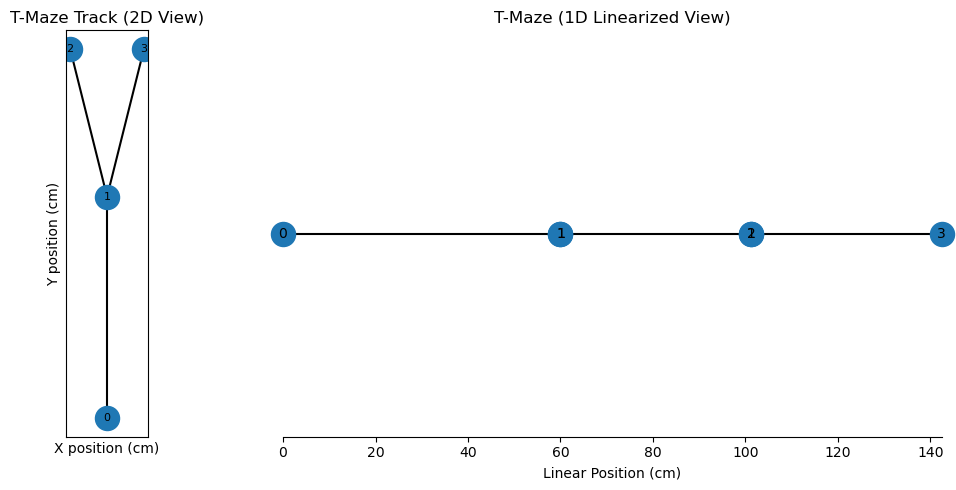

In [7]:
# Visualize T-maze
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_track_graph(tmaze, ax=ax1, node_size=300)
ax1.set_title('T-Maze Track (2D View)')
ax1.set_aspect('equal')
ax1.set_xlabel('X position (cm)')
ax1.set_ylabel('Y position (cm)')

# Show linearized view with inferred edge order
plot_graph_as_1D(tmaze, edge_order=edge_order, ax=ax2)
ax2.set_title('T-Maze (1D Linearized View)')
ax2.set_xlabel('Linear Position (cm)')

plt.tight_layout()
plt.show()

### Example 4: Complete Builder Showcase

Here are all available track builders:

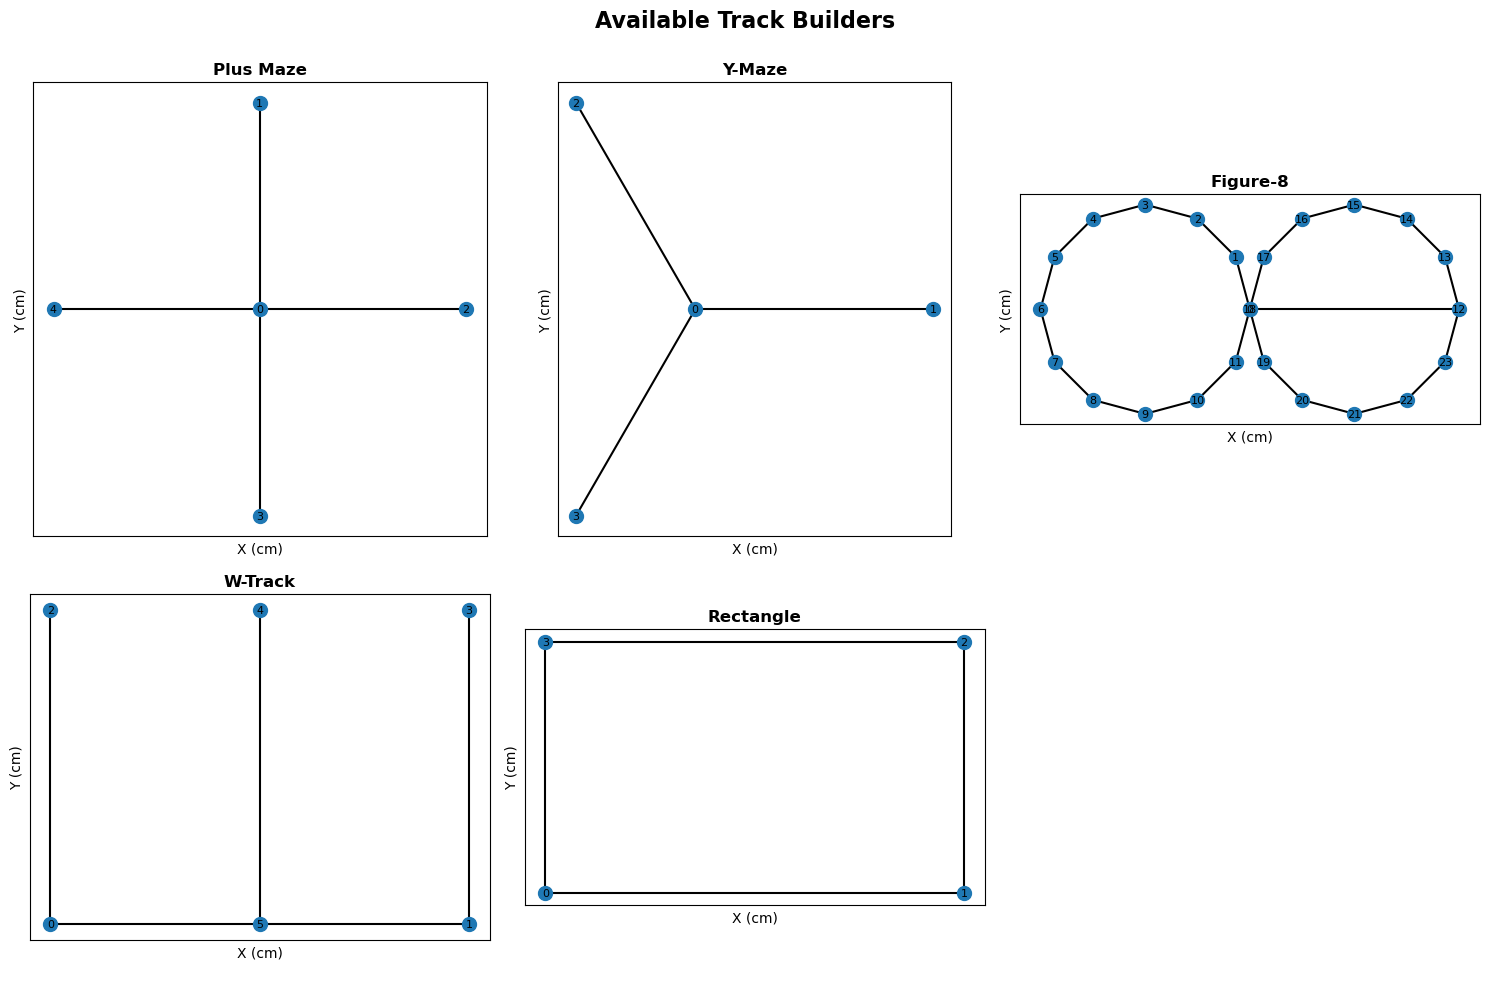


📊 Track Statistics:
Plus Maze       -  5 nodes,  4 edges
Y-Maze          -  4 nodes,  3 edges
Figure-8        - 24 nodes, 25 edges
W-Track         -  6 nodes,  5 edges
Rectangle       -  4 nodes,  4 edges


In [8]:
# Create examples of each track type
tracks = {
    'Plus Maze': make_plus_maze_track(arm_length=40),
    'Y-Maze': make_ymaze_track(arm_length=50, arm_angle_deg=120),
    'Figure-8': make_figure8_track(loop_radius=30, n_segments_per_loop=12),
    'W-Track': make_wtrack(width=80, height=60),
    'Rectangle': make_rectangular_track(width=100, height=60),
}

# Visualize all tracks
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, (name, track) in zip(axes, tracks.items()):
    plot_track_graph(track, ax=ax, node_size=100)
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_aspect('equal')
    ax.set_xlabel('X (cm)', fontsize=10)
    ax.set_ylabel('Y (cm)', fontsize=10)

# Hide the last subplot
axes[-1].axis('off')

plt.suptitle('Available Track Builders', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n📊 Track Statistics:")
for name, track in tracks.items():
    print(f"{name:15} - {track.number_of_nodes():2} nodes, {track.number_of_edges():2} edges")

### Using Track Builders for Analysis

Let's simulate a complete trajectory on a T-maze and linearize it:

In [9]:
# Create T-maze
tmaze = make_tmaze_track(stem_length=100, arm_length=60)

# Simulate realistic trajectory: go up stem, choose left arm
t = np.linspace(0, 1, 100)

# Stem portion (bottom to top)
stem_pos = np.column_stack([
    np.zeros(50),    # x = 0
    t[:50] * 100     # y from 0 to 100
])

# Left arm portion (horizontal movement)
arm_pos = np.column_stack([
    -t[50:] * 60,    # x from 0 to -60
    np.full(50, 100) # y = 100
])

positions = np.vstack([stem_pos, arm_pos])

# Add realistic tracking noise
positions += np.random.normal(0, 2, positions.shape)

# Linearize the trajectory
result = get_linearized_position(positions, tmaze, use_HMM=True)

print(f"Linearized {len(positions)} positions")
print(f"Linear position range: {result['linear_position'].min():.1f} to {result['linear_position'].max():.1f} cm")

Linearized 100 positions
Linear position range: 0.0 to 139.4 cm


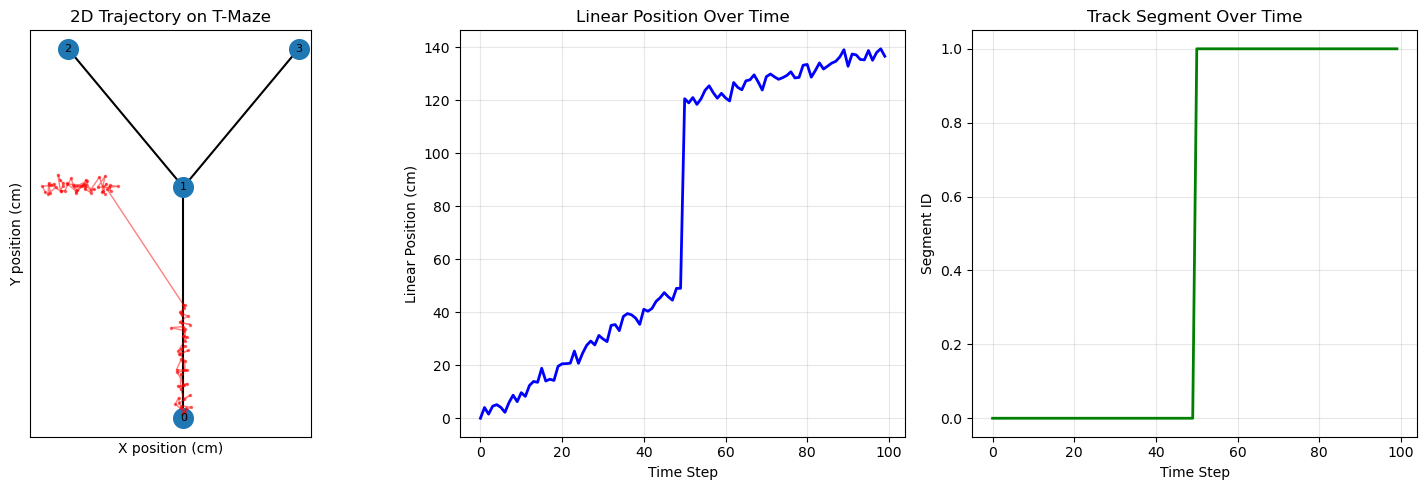


💡 Notice how linear position increases smoothly as the animal moves through the maze.


In [10]:
# Visualize the trajectory and linearization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 2D trajectory on track
plot_track_graph(tmaze, ax=axes[0], node_size=200)
axes[0].plot(positions[:, 0], positions[:, 1], 'r.-', alpha=0.5, markersize=3, linewidth=1)
axes[0].set_title('2D Trajectory on T-Maze')
axes[0].set_aspect('equal')
axes[0].set_xlabel('X position (cm)')
axes[0].set_ylabel('Y position (cm)')

# Linear position over time
axes[1].plot(result['linear_position'], 'b-', linewidth=2)
axes[1].set_title('Linear Position Over Time')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Linear Position (cm)')
axes[1].grid(True, alpha=0.3)

# Track segment over time
axes[2].plot(result['track_segment_id'], 'g-', linewidth=2)
axes[2].set_title('Track Segment Over Time')
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('Segment ID')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Notice how linear position increases smoothly as the animal moves through the maze.")

---
## Part 2: Validation & Quality Control

### Concept
Before analyzing linearized data, you should validate:
1. **Track structure** - Is the graph properly connected?
2. **Linearization quality** - How well do positions project onto the track?
3. **Outliers** - Are there suspicious positions that might be tracking errors?

The validation functions help you identify and fix these issues.

### Example 5: Track Graph Validation

Always validate your track structure before use:

In [11]:
# Validate a track
track = make_linear_track(100)
report = check_track_graph_validity(track)

print("TRACK VALIDATION REPORT")
print("=" * 60)
print(f"✓ Track is valid: {report['valid']}")
print(f"\nStructure:")
print(f"  - Nodes: {report['n_nodes']}")
print(f"  - Edges: {report['n_edges']}")
print(f"  - Connected: {report['is_connected']}")

if report['warnings']:
    print(f"\n⚠️  Warnings:")
    for warning in report['warnings']:
        print(f"  • {warning}")
if report['errors']:
    print(f"\n❌ Errors:")
    for error in report['errors']:
        print(f"  • {error}")

print("=" * 60)

TRACK VALIDATION REPORT
✓ Track is valid: True

Structure:
  - Nodes: 2
  - Edges: 1
  - Connected: True


### Example 6: Detecting Track Issues

Let's intentionally create a problematic track to see validation in action:

Disconnected Track Validation:
Valid: True
Connected: False

Warnings:
  ⚠️ Graph is not connected (2 components). Some positions may not be reachable.


/Users/edeno/miniconda3/envs/track_linearization/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


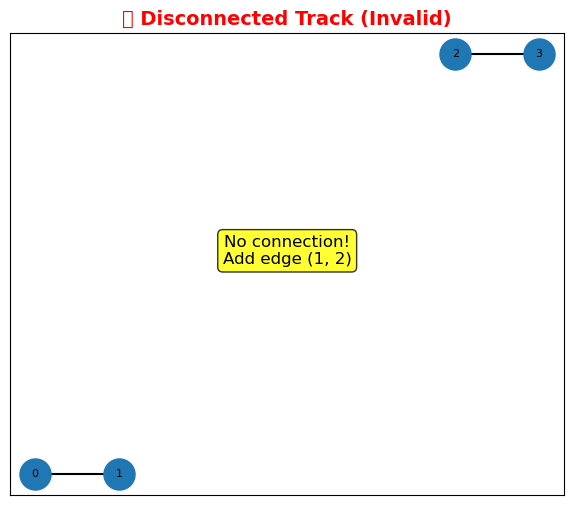

In [ ]:
# Create a disconnected track (common mistake!)
bad_track = make_track_graph(
    node_positions=[(0, 0), (10, 0), (50, 50), (60, 50)],
    edges=[(0, 1), (2, 3)]  # Two separate components!
)

report = check_track_graph_validity(bad_track)

print("Disconnected Track Validation:")
print(f"Valid: {report['valid']}")
print(f"Connected: {report['is_connected']}")

if report['warnings']:
    print(f"\nWarnings:")
    for warning in report['warnings']:
        print(f"  ⚠️ {warning}")

# Visualize the problem
fig, ax = plt.subplots(figsize=(8, 6))
plot_track_graph(bad_track, ax=ax, node_size=500)
ax.set_title('❌ Disconnected Track (Invalid)', color='red', fontsize=14, fontweight='bold')
ax.set_aspect('equal')
ax.text(30, 25, 'No connection!\nAdd edge (1, 2)',
       fontsize=12, ha='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
plt.show()

### Example 7: Projection Confidence Scores

Confidence scores (0-1) indicate how well positions project onto the track.

**Interpretation:**
- **High confidence (>0.9)**: Position is very close to the track
- **Medium confidence (0.7-0.9)**: Position is reasonably close
- **Low confidence (<0.7)**: Position may be far from track or a tracking error

In [13]:
# Create trajectory with varying quality
track = make_linear_track(100)

# Perfect positions on track
clean_positions = np.column_stack([np.linspace(0, 100, 80), np.zeros(80)])

# Add noise to some positions (simulating tracking errors)
noisy_positions = clean_positions.copy()
noisy_positions[30:35] += np.random.normal(0, 15, (5, 2))  # Large errors
noisy_positions[60:65] += np.random.normal(0, 8, (5, 2))   # Medium errors

# Linearize
result = get_linearized_position(noisy_positions, track)

# Calculate confidence
confidence = get_projection_confidence(noisy_positions, track, result)

print(f"Confidence statistics:")
print(f"  Mean: {np.mean(confidence):.3f}")
print(f"  Min:  {np.min(confidence):.3f}")
print(f"  Max:  {np.max(confidence):.3f}")
print(f"\nLow confidence positions (< 0.7): {np.sum(confidence < 0.7)}")

Confidence statistics:
  Mean: 0.887
  Min:  0.000
  Max:  1.000

Low confidence positions (< 0.7): 9


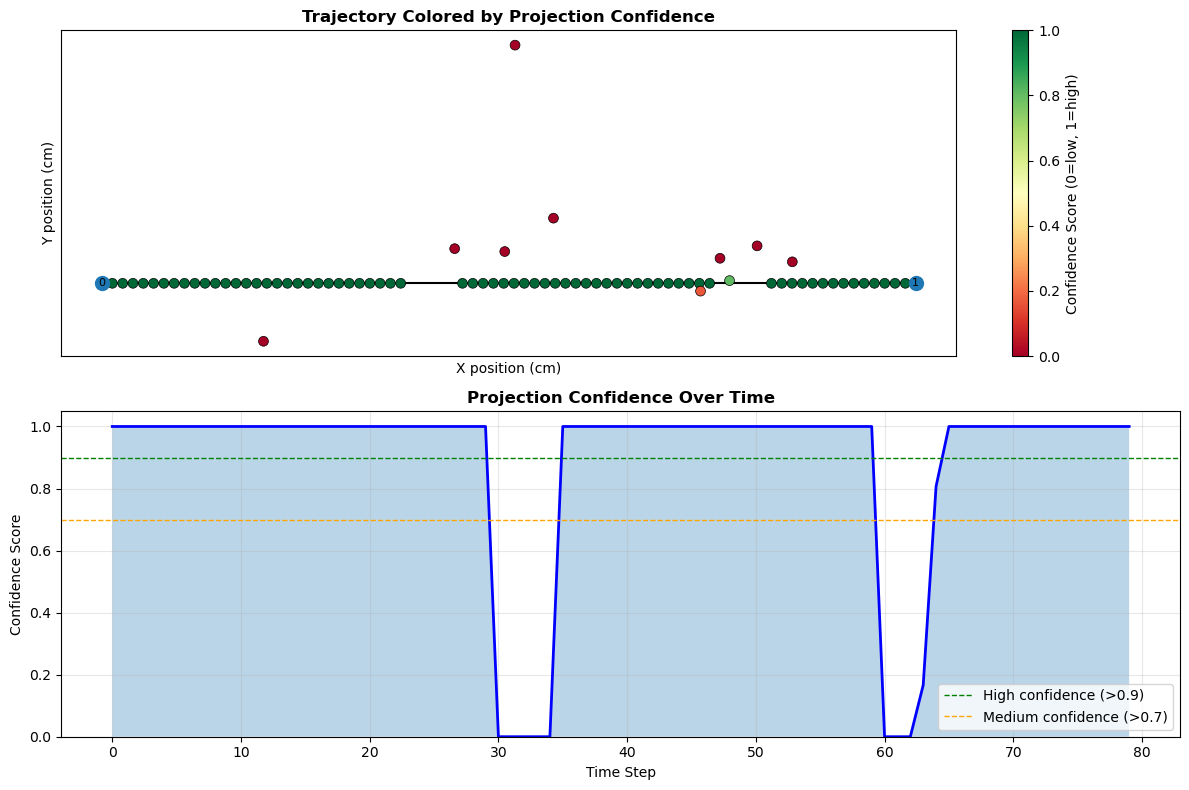

In [ ]:
# Visualize confidence scores
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Trajectory colored by confidence
scatter = ax1.scatter(noisy_positions[:, 0], noisy_positions[:, 1],
                     c=confidence, cmap='RdYlGn', s=50, vmin=0, vmax=1,
                     edgecolors='black', linewidths=0.5)
plot_track_graph(track, ax=ax1, node_size=100)
plt.colorbar(scatter, ax=ax1, label='Confidence Score (0=low, 1=high)')
ax1.set_title('Trajectory Colored by Projection Confidence', fontsize=12, fontweight='bold')
ax1.set_xlabel('X position (cm)')
ax1.set_ylabel('Y position (cm)')

# Confidence over time
ax2.plot(confidence, 'b-', linewidth=2)
ax2.axhline(0.9, color='green', linestyle='--', linewidth=1, label='High confidence (>0.9)')
ax2.axhline(0.7, color='orange', linestyle='--', linewidth=1, label='Medium confidence (>0.7)')
ax2.fill_between(range(len(confidence)), 0, confidence, alpha=0.3)
ax2.set_title('Projection Confidence Over Time', fontsize=12, fontweight='bold')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Confidence Score')
ax2.set_ylim([0, 1.05])
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

💡 **Interpretation:** Green points are high confidence (close to track), yellow/red points are low confidence (far from track or noisy).

### Example 8: Automatic Outlier Detection

Detect positions that are likely tracking errors or off-track behavior:

In [15]:
# Create circular track
track = make_circular_track(radius=50, n_segments=24)

# Generate circular trajectory
theta = np.linspace(0, 2*np.pi, 100)
positions = np.column_stack([50 * np.cos(theta), 50 * np.sin(theta)])

# Add intentional outliers (tracking errors)
positions[25] = [100, 100]  # Far from track
positions[50] = [80, 80]    # Far from track
positions[75] = [-10, 90]   # Far from track

# Linearize
result = get_linearized_position(positions, track)

# Detect outliers
outlier_report = detect_linearization_outliers(
    positions, track, result,
    threshold=3.0  # Number of standard deviations
)

print("OUTLIER DETECTION REPORT")
print("=" * 60)
print(f"Total outliers detected: {outlier_report['n_outliers']}")
print(f"Outlier indices: {outlier_report['outlier_indices']}")
print(f"\nReasons:")
for idx, reason in zip(outlier_report['outlier_indices'], outlier_report['outlier_reasons']):
    print(f"  Position {idx}: {reason}")
print("=" * 60)

OUTLIER DETECTION REPORT
Total outliers detected: 8
Outlier indices: [25 26 46 50 51 54 75 76]

Reasons:
  Position 25: far from track (distance=91.42 > 0.72); large jump (delta=36.79 > 3.18)
  Position 26: large jump (delta=43.11 > 3.18)
  Position 46: large jump (delta=287.95 > 3.18)
  Position 50: far from track (distance=63.14 > 0.72); large jump (delta=194.21 > 3.18)
  Position 51: large jump (delta=204.10 > 3.18)
  Position 54: large jump (delta=16.21 > 3.18)
  Position 75: far from track (distance=40.96 > 0.72); large jump (delta=162.11 > 3.18)
  Position 76: large jump (delta=155.79 > 3.18)


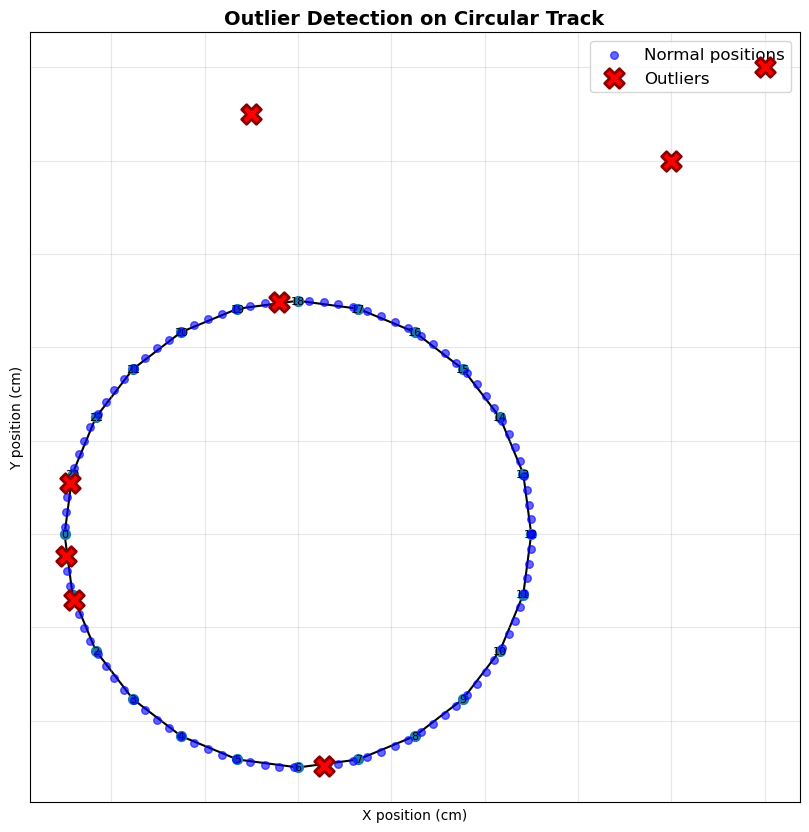


💡 Red X markers show automatically detected outlier positions.


In [ ]:
# Visualize outliers
fig, ax = plt.subplots(figsize=(10, 10))

# Plot track
plot_track_graph(track, ax=ax, node_size=50)

# Plot normal points
normal_mask = np.ones(len(positions), dtype=bool)
normal_mask[outlier_report['outlier_indices']] = False
ax.scatter(positions[normal_mask, 0], positions[normal_mask, 1],
          c='blue', s=30, alpha=0.6, label='Normal positions', zorder=5)

# Plot outliers
ax.scatter(positions[outlier_report['outlier_indices'], 0],
          positions[outlier_report['outlier_indices'], 1],
          c='red', s=200, marker='X', label='Outliers',
          zorder=10, edgecolors='darkred', linewidths=2)

ax.set_title('Outlier Detection on Circular Track', fontsize=14, fontweight='bold')
ax.set_xlabel('X position (cm)')
ax.set_ylabel('Y position (cm)')
ax.legend(fontsize=12, loc='upper right')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.show()

print("\n💡 Red X markers show automatically detected outlier positions.")

### Example 9: Comprehensive Quality Assessment

Get a complete quality report with a single function:

In [17]:
# Create trajectory with some issues
track = make_tmaze_track(stem_length=100, arm_length=60)

# Simulate realistic trajectory with noise
positions = np.vstack([
    np.column_stack([np.zeros(50), np.linspace(0, 100, 50)]),      # Stem
    np.column_stack([np.linspace(0, -60, 50), np.full(50, 100)])   # Left arm
])
positions += np.random.normal(0, 3, positions.shape)  # Tracking noise

# Add some problematic points
positions[30] += [20, 20]  # Large deviation
positions[60] += [15, 15]  # Another deviation

# Linearize
result = get_linearized_position(positions, track, use_HMM=True)

# Comprehensive validation
validation = validate_linearization(positions, track, result, strict=False)

# Display report
print("="*70)
print("COMPREHENSIVE LINEARIZATION VALIDATION")
print("="*70)
print(f"\n📊 Overall Quality Score: {validation['quality_score']:.1%}")

print(f"\n📈 Detailed Metrics:")
for metric, value in validation['metrics'].items():
    print(f"   {metric:25} {value:.4f}")

if validation['warnings']:
    print(f"\n⚠️  Warnings ({len(validation['warnings'])}):")
    for warning in validation['warnings']:
        print(f"   • {warning}")

if validation['recommendations']:
    print(f"\n💡 Recommendations:")
    for rec in validation['recommendations']:
        print(f"   → {rec}")

# Interpret score
print("\n" + "="*70)
score = validation['quality_score']
if score > 0.9:
    print("✅ Excellent linearization quality!")
elif score > 0.75:
    print("✓ Good linearization quality")
elif score > 0.6:
    print("⚠ Fair quality - review warnings before analysis")
else:
    print("❌ Poor quality - address issues before proceeding")
print("="*70)

COMPREHENSIVE LINEARIZATION VALIDATION

📊 Overall Quality Score: 71.5%

📈 Detailed Metrics:
   mean_confidence           0.5045
   low_confidence_percentage 45.0000
   outlier_count             29.0000
   outlier_percentage        29.0000
   mean_projection_distance  13.0963
   median_projection_distance 6.1173

⚠️  Warnings (2):
   • Low mean confidence: 0.50 (45.0% of positions have confidence < 0.5)
   • Found 29 outliers (29.0% of positions)

💡 Recommendations:
   → Consider using HMM mode (use_HMM=True) for noisy data
   → High outlier rate suggests track structure may not match actual paths
   → Verify track graph structure with plot_track_graph()

⚠ Fair quality - review warnings before analysis


---
## Part 3: Interactive Track Builder

### Concept
When you have a photograph or video frame of your experimental setup, you can build a track interactively by clicking on the image. This is much faster than measuring coordinates manually.

### How It Works in Jupyter

The interactive builder works differently in Jupyter notebooks:

1. **Cell 1**: Start the builder → plot appears (returns immediately)
2. **Interact**: Click on the image to add nodes and edges
3. **Cell 2**: Retrieve your results

This two-step process is necessary because Jupyter's event loop runs separately from Python execution.

### Example 10: Interactive Builder (Step 1 - Start)

**Instructions:**
1. Run this cell
2. Click on the image to add nodes (red dots)
3. Press 'e' then click-and-drag to create edges (blue lines)
4. Press 'a' to return to node-adding mode
5. When done, run the next cell to get results


INTERACTIVE TRACK BUILDER - CONTROLS
MODES (press key to switch):
  'a' key:        ADD NODE mode - Click anywhere to add node
  'e' key:        CREATE EDGE mode - Click & drag between nodes
  'x' key:        DELETE NODE mode - Click on node to delete

ACTIONS:
  Click:          Action depends on current mode (see above)
  Click & Drag:   In EDGE mode, creates edge between nodes

KEYBOARD SHORTCUTS:
  'u' key:        Undo last node
  'Backspace':    Delete last edge
  'h' key:        Show this help

VISUAL CUES:
  Green banner:   ADD NODE mode
  Blue banner:    CREATE EDGE mode
  Red banner:     DELETE NODE mode
  Yellow circle:  Selected node during edge creation
  Yellow dashed:  Edge preview while dragging

📌 JUPYTER: Build your track, then retrieve results in a new cell
   (See instructions below after running this cell)



/Users/edeno/Documents/GitHub/track_linearization/src/track_linearization/track_builders.py:956: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


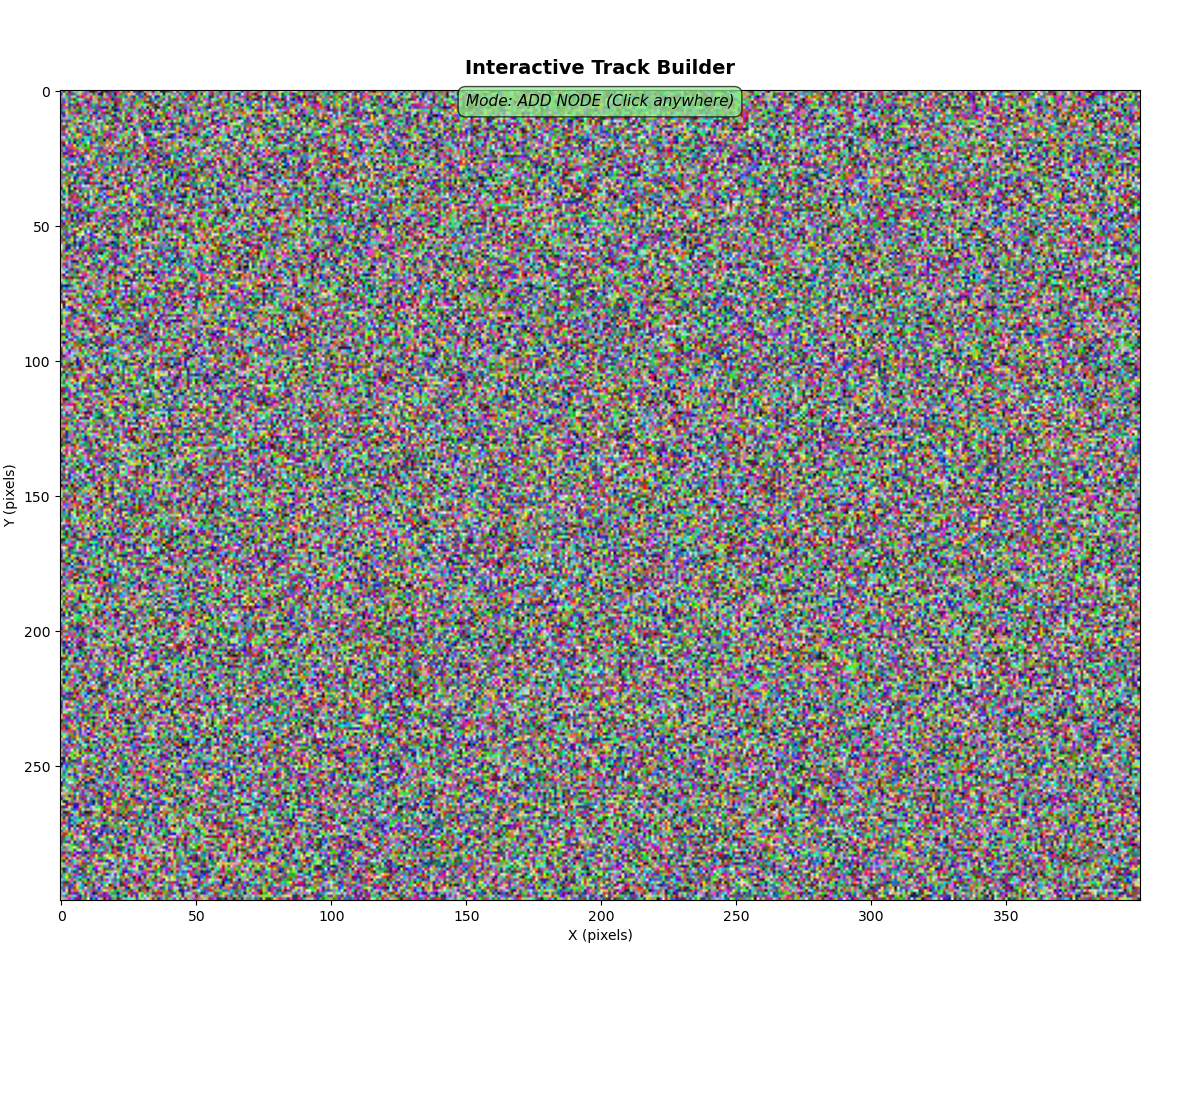


🎯 JUPYTER MODE - INTERACTIVE BUILDER
The plot is displayed above. It is ALREADY INTERACTIVE!

To build your track:
  1. Click on the image to add nodes (red dots appear)
  2. Press 'e' then click & drag to create edges (blue lines)
  3. Press 'a' to return to ADD mode

To get your results, run this in a NEW cell:

  import matplotlib.pyplot as plt
  from track_linearization import _build_track_from_state
  state = plt.gcf()._track_builder_state
  result = _build_track_from_state(state, scale=1.0)
  print(result)




In [18]:
# Switch to widget backend for interactivity
%matplotlib widget

# For Jupyter, you need ipympl installed: pip install ipympl

# Create test image (or load your own with plt.imread('path/to/image.png'))
test_image = np.random.rand(300, 400, 3)

# Start interactive builder
from track_linearization import make_track_from_image_interactive
_ = make_track_from_image_interactive(image_array=test_image, scale=1.0)

# The plot appears above - it's ALREADY interactive!
# Click on it to add nodes, then run the next cell when done

### Example 10: Interactive Builder (Step 2 - Retrieve Results)

After you've built your track above, run this cell to get the results:

In [19]:
# Retrieve results from interactive builder
import matplotlib.pyplot as plt
from track_linearization import _build_track_from_state

state = plt.gcf()._track_builder_state
result = _build_track_from_state(state, scale=1.0)

print(f"Nodes created: {len(result['node_positions'])}")
print(f"Edges created: {len(result['edges'])}")

if result['track_graph']:
    print("\n✓ Track graph created successfully!")

    # Visualize the result
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_track_graph(result['track_graph'], ax=ax, node_size=300)
    ax.set_title('Your Custom Track', fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    plt.show()
else:
    print("\nNo track created. Add some nodes in the interactive plot above!")

Nodes created: 0
Edges created: 0

No track created. Add some nodes in the interactive plot above!


### Alternative: Manual Point Specification

If interactive mode doesn't work in your environment, you can specify points manually:

✓ Created track with 4 nodes and 3 edges


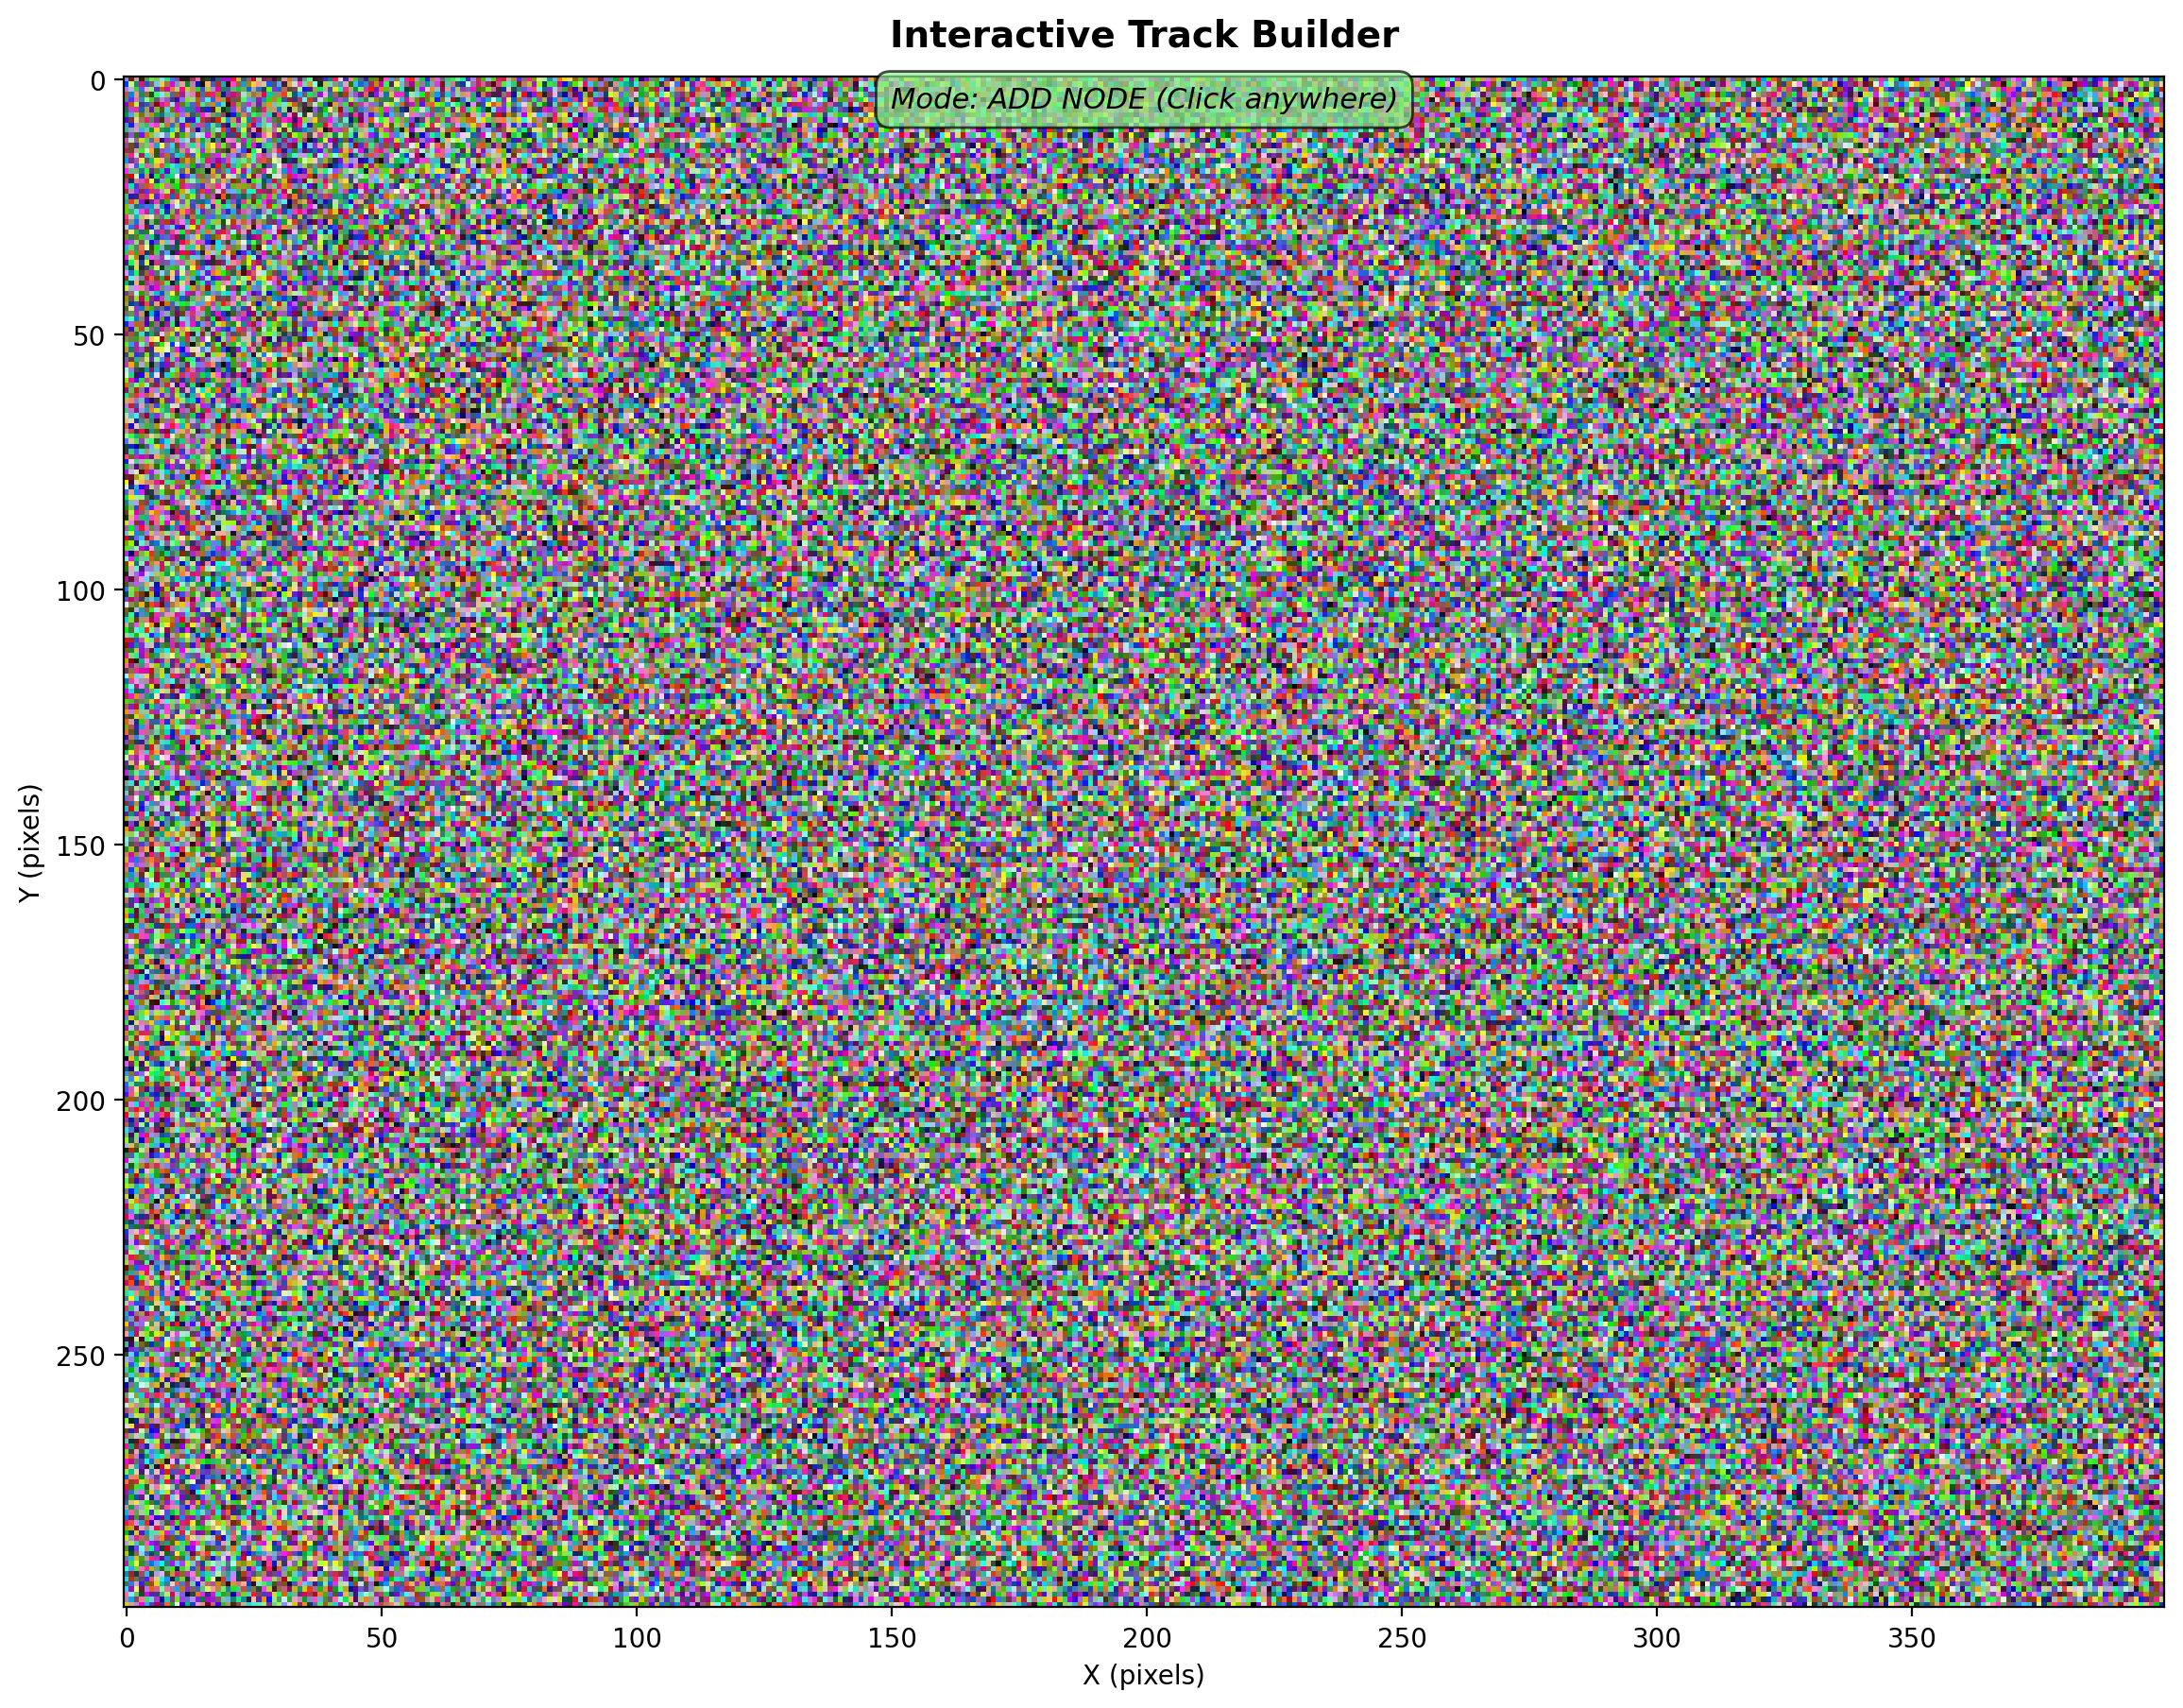

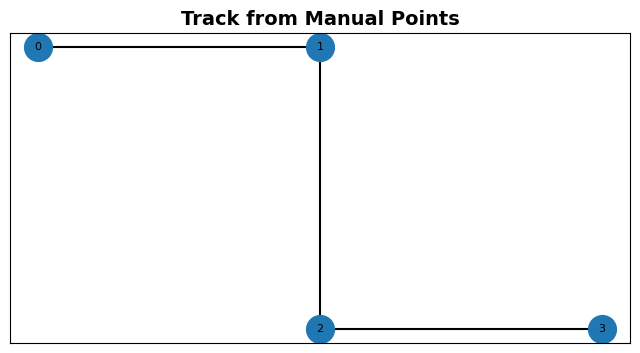


Scaled positions (with scale=0.5):
  Node 0: (50.0, 100.0) cm
  Node 1: (100.0, 100.0) cm
  Node 2: (100.0, 50.0) cm
  Node 3: (150.0, 50.0) cm


In [20]:
%matplotlib inline

# Define node positions manually (in pixel coordinates)
node_positions = [
    (100, 200),  # Node 0
    (200, 200),  # Node 1
    (200, 100),  # Node 2
    (300, 100),  # Node 3
]

# Define edges connecting the nodes
edges = [(0, 1), (1, 2), (2, 3)]

# Create track with scaling (e.g., 0.5 cm per pixel)
from track_linearization import make_track_from_points
result = make_track_from_points(node_positions, edges, scale=0.5)

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
plot_track_graph(result['track_graph'], ax=ax, node_size=400)
ax.set_title('Track from Manual Points', fontsize=14, fontweight='bold')
ax.set_aspect('equal')
plt.show()

print(f"\nScaled positions (with scale=0.5):")
for i, pos in enumerate(result['node_positions']):
    print(f"  Node {i}: {pos} cm")

---
## Part 4: Best Practices

### Choosing the Right Track Builder

| Experiment Type | Track Builder | Notes |
|----------------|---------------|-------|
| Linear track running | `make_linear_track()` | Simple 1D path |
| Circular/annular maze | `make_circular_track()` | Adjust `n_segments` for smoothness (≥24) |
| T-maze alternation | `make_tmaze_track()` | Use `arm_spacing` for gap between arms |
| Open field perimeter | `make_rectangular_track()` | For boundary tracking |
| Custom/complex setup | `make_track_from_image_interactive()` | Build from setup photo |

### Validation Checklist

Before analyzing linearized data, always:

```python
# 1. Validate track structure
track_report = check_track_graph_validity(track)
assert track_report['valid'], f"Fix track: {track_report['errors']}"

# 2. Assess linearization quality
validation = validate_linearization(positions, track, result)
if validation['quality_score'] < 0.75:
    print("⚠ Review recommendations:")
    for rec in validation['recommendations']:
        print(f"  → {rec}")

# 3. Check for outliers
outliers = detect_linearization_outliers(positions, track, result)
if outliers['n_outliers'] > len(positions) * 0.05:
    print(f"⚠ High outlier rate: {outliers['n_outliers']/len(positions):.1%}")

# 4. Verify confidence
confidence = get_projection_confidence(positions, track, result)
if np.mean(confidence) < 0.8:
    print("⚠ Low mean confidence - check track geometry")
```

### Common Issues and Solutions

#### Issue: Low Confidence Scores
**Possible causes:**
- Position data doesn't match track geometry
- Wrong coordinate units (pixels vs cm)
- Track too far from actual positions

**Solutions:**
- Visualize trajectory on track: `plot_track_graph(track); plt.plot(positions[:, 0], positions[:, 1], 'r.')`
- Check coordinate scaling
- Verify track matches experimental setup

#### Issue: Many Outliers
**Possible causes:**
- Noisy position tracking
- Tracking failures
- Off-track behavior

**Solutions:**
- Smooth/filter positions before linearization
- Adjust outlier threshold parameter
- Remove outliers from analysis

#### Issue: Disconnected Track
**Cause:** Track has separate components

**Solution:**
```python
report = check_track_graph_validity(track)
if not report['is_connected']:
    print("⚠️ Track is disconnected!")
    for warning in report['warnings']:
        print(f"  {warning}")
    print("Add edges to connect all nodes!")
```

---
## Summary

You've learned how to:

✅ **Track Builders** - Create 8+ track geometries with single function calls  
✅ **Validation** - Check track validity and linearization quality  
✅ **Quality Control** - Calculate confidence and detect outliers  
✅ **Interactive Building** - Create custom tracks from images  
✅ **Best Practices** - Apply quality checks and troubleshoot issues  

### Next Steps

1. **Apply to your data**: Use appropriate track builder for your experiments
2. **Validate always**: Run quality checks before analysis
3. **Review the main tutorial**: Learn about edge mapping and HMM inference
4. **Explore documentation**: Check function docstrings with `help(function_name)`

### Resources

- **Main Tutorial**: [track_linearization_tutorial.ipynb](track_linearization_tutorial.ipynb)
- **GitHub**: [github.com/LorenFrankLab/track_linearization](https://github.com/LorenFrankLab/track_linearization)  
- **Documentation**: Use `help()` on any function
- **Issues**: Report problems on GitHub

Happy tracking! 🎯